In [1]:
!pip install datasets
!pip install --upgrade jupyter ipywidgets



Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 542 kB 7.7 MB/s eta 0:00:01
     |████████████████████████████████| 116 kB 115.9 MB/s eta 0:00:01
     |████████████████████████████████| 194 kB 108.3 MB/s eta 0:00:01
     |████████████████████████████████| 1.3 MB 93.5 MB/s eta 0:00:01
     |████████████████████████████████| 132 kB 116.4 MB/s eta 0:00:01
     |████████████████████████████████| 40.9 MB 79.0 MB/s eta 0:00:01
     |████████████████████████████████| 129 kB 106.0 MB/s eta 0:00:01
     |████████████████████████████████| 308 kB 112.4 MB/s eta 0:00:01
     |████████████████████████████████| 240 kB 139.4 MB/s eta 0:00:01
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 5.0.0
    Uninstalling pyarrow-5.0.0:
      Successfully uninstalled pyarrow-5.0.0
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     |████████████████████████████████| 139 kB 7.2 MB/s eta 0:00:01
   

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch, transformers
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer
import torch.nn as nn
import torch.nn.functional as F
#from datasets import load_dataset
import pandas as pd, numpy as np
from torch import cuda
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import datetime
import warnings

# Ignore all warnings
warnings.filterwarnings('ignore')



In [3]:
#!nvidia-smi

In [3]:
#global params for training

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", padding = True, return_tensors = "pt",is_split_into_words=True)
batch_size = 32
epoch = 100
max_tokenizer_len = 512

# train_loss_list = []
# val_loss_list =[]
if cuda.is_available():
    device = torch.device('cuda:0')
    print(device)
else:
    device = 'cpu'
#print(device)
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
#os.environ["MKL_DEBUG_CPU_TYPE"] = "5"
glue_task = 'mrpc'
labels = ['Class 0', 'Class 1']
global_tr_loss = torch.inf
global_val_loss = torch.inf
#print(global_tr_loss)
model_path = os.path.join("data")
print(model_path)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

cuda:0
data


In [4]:
from datasets import load_dataset
import pandas as pd, numpy as np

#pip install datasets

from datasets import load_dataset
#mrpc = load_dataset('glue', 'sst2')

dataset = load_dataset('glue','mrpc') 


Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

In [5]:
#dataset
# msr_paraphrase_test.txt
# msr_paraphrase_train.txt
import pandas as pd , os
file_path = os.path.join("data","msr_paraphrase_train.txt")
print(file_path)

df = pd.read_csv(file_path,sep='\t', on_bad_lines='skip')
len(df)


data/msr_paraphrase_train.txt


3938

In [7]:
train_df_temp = pd.DataFrame(dataset['train'])
df_test = pd.DataFrame(dataset['test'])


In [8]:
len(df_test)

1725

# Train Test split
    
    

In [9]:
seed = 42
# Randomly shuffle the DataFrame
df_shuffled = train_df_temp.sample(frac=1, random_state=seed)
train_ratio = 0.8
# Calculate the number of samples for training
train_size = int(train_ratio * len(df_shuffled))

# Split the shuffled DataFrame into training and testing sets
df_train = df_shuffled[:train_size]
df_val = df_shuffled[train_size:]


In [10]:
print(len(df_train))
print(len(df_val))

2934
734


In [11]:
df_train.head()

,sentence1,sentence2,label,idx
179,Tibco has used the Rendezvous name since 1994 ...,Tibco has used the Rendezvous name since 1994 ...,1,201
2679,Most of the alleged spammers engaged in fraudu...,""" Spam knows no borders , "" said Brad Smith , ...",0,2977
3133,"Yesterday , Taiwan reported 35 new infections ...",The island reported another 35 probable cases ...,1,3482
1061,"A month ago , the Commerce Department estimate...","A month ago , the Commerce Department said GDP...",1,1187
1091,Gillespie sent a letter to CBS President Lesli...,Republican National Committee Chairman Ed Gill...,0,1220


<AxesSubplot:xlabel='label', ylabel='count'>

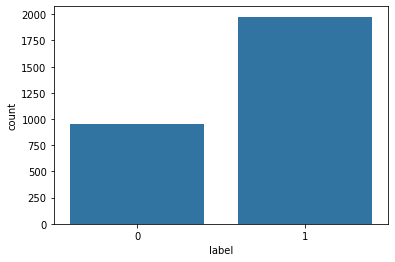

In [12]:
## Lets check the labal distributions
import seaborn as sns
sns.countplot(data = df_train ,x = df_train.label)

### This dataset is imbalanced, calculating weight adjustments to pass to the loss function

In [13]:
# get unique values for number of classes
num_classes = len(df_train.label.unique())
print(num_classes)
# get the number of samples for each class
class_dist = [0]*num_classes
print(class_dist)
# create a zero vector that equals the number of labels
for i in range(num_classes):
    class_dist[i]= (df_train['label']== i).sum()
print(class_dist)
class_dist = torch.tensor(class_dist)
print(type(class_dist))

2
[0, 0]
[957, 1977]
<class 'torch.Tensor'>


In [14]:
#label_0_wt = len(df_train) / (num_samples_in_class_i * num_classes)
weight_vector = torch.zeros(class_dist.shape)
for i in range(num_classes):
    weight_vector[i] = len(df_train) / (class_dist[i] * num_classes)
print(weight_vector)  

tensor([1.5329, 0.7420])


In [15]:
# Test the tokenizer:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", padding = True, return_tensors = "pt" , truncate = True, max_length  = 512)

#encoding multiple sentences with a tokenizer https://discuss.huggingface.co/t/use-two-sentences-as-inputs-for-sentence-classification/5444/3

encoding = tokenizer(df_train['sentence1'][9], df_train['sentence2'][9] , padding="max_length", truncation=True)



In [16]:
encoding

{'input_ids': [101, 156, 22705, 1116, 1104, 9066, 11656, 1732, 117, 170, 1277, 2610, 1419, 1114, 1317, 2982, 1113, 1103, 2319, 117, 3152, 1167, 1190, 123, 3029, 119, 102, 156, 22705, 1116, 1104, 161, 7903, 2204, 1479, 3029, 1107, 1346, 2597, 117, 1229, 6117, 1104, 9066, 11656, 1732, 117, 170, 1277, 2610, 1419, 1114, 1317, 2982, 1113, 1103, 2319, 117, 1127, 1146, 123, 3029, 119, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

### Data loaders and Dataset for batched training

In [17]:
class dataset_pyt(Dataset):
    def __init__(self, df):
        self.df = df
        self.num_classes = len(df.label.unique())
                
    def __getitem__(self, idx):
        text1 = self.df.iloc[idx]['sentence1']
        text2 = self.df.iloc[idx]['sentence2']
        x = tokenizer(text1,text2 ,padding="max_length",truncation=True, return_tensors="pt" )
        #print(f"inside the loader and index = {idx}")
        x_dict = {}
        x_dict['id'] = x['input_ids']
        x_dict['token_type'] = x['token_type_ids']
        x_dict['attention_mask'] = x['attention_mask']
        #label = torch.tensor(self.df.iloc[idx]['label'] , dtype=torch.float32)
        label_onehot = torch.nn.functional.one_hot(torch.tensor(self.df.iloc[idx]['label']), num_classes= num_classes).float()
        
        #print(f"inside the dataset class ..label_vec_t = {label_onehot}")
        return x_dict, label_onehot
        
    def __len__(self):
        #return the length of the dataframe
        return len(self.df)
    

In [18]:
train_dataset = dataset_pyt(df_train)
val_dataset = dataset_pyt(df_val)
test_dataset = dataset_pyt(df_test)

train_loader = DataLoader(train_dataset,batch_size = batch_size, shuffle = True , num_workers = 0, pin_memory = False)
val_loader = DataLoader(val_dataset,batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset,batch_size = batch_size, shuffle = False)

    

### Training the model

In [19]:
class clf_model(torch.nn.Module):
    def __init__(self):
        super(clf_model, self).__init__()
        self.backbone = transformers.BertModel.from_pretrained('bert-base-uncased')
        #self.norm_layer = torch.nn.LayerNorm()
        self.linear_layer = torch.nn.Linear(768, 2)
         
                  
    def forward(self,ids ,token_type,att_mask):
        #print(f"shape of ids->{ids.shape}")
           #ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False     
        _,x = self.backbone(ids , token_type_ids =token_type ,attention_mask= att_mask, return_dict=False)
                
        x = self.linear_layer(x)
        #print(f"shape after linear_layer->{x.shape}")
        #print(f"x after linear ->{x}")
        #layer_norm = torch.nn.LayerNorm(x.shape[1])
        #x = layer_norm(x)
        #print(f"x fter layer norm = {x}")
        return x

In [20]:
#self.l2 = torch.nn.Dropout(0.3)
class clf_model_drp(torch.nn.Module):
    def __init__(self):
        super(clf_model_drp, self).__init__()
        self.backbone = transformers.BertModel.from_pretrained('bert-base-uncased')
        self.dropout = torch.nn.Dropout(0.8)
        self.linear_layer = torch.nn.Linear(768, 2)
         
                  
    def forward(self,ids ,token_type,att_mask):
        #print(f"shape of ids->{ids.shape}")
           #ids, attention_mask = mask, token_type_ids = token_type_ids, return_dict=False     
        _,x = self.backbone(ids , token_type_ids =token_type ,attention_mask= att_mask, return_dict=False)
        x = self.dropout(x)
        x = self.linear_layer(x)
        #print(f"shape after linear_layer->{x.shape}")
        #print(f"x after linear ->{x}")
        #layer_norm = torch.nn.LayerNorm(x.shape[1])
        #x = layer_norm(x)
        #print(f"x fter layer norm = {x}")
        return x


In [21]:
def plot_confusion_matrix(y_true,y_pred, labels):
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.2)  # Adjust font scale for better readability
    conf_mat = confusion_matrix(y_true, y_pred)
    
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()



In [22]:
@torch.no_grad
def eval_model(val_loader, model, epoch , device = device,):
    global global_val_loss
    m = nn.Softmax()
    model.eval()
    model.to(device)
    e = epoch+1
    val_loss_list = []
    criterion = torch.nn.BCEWithLogitsLoss()
    print(f"inside validation data for epoch {e}")
    y_hat_val_list = []
    y_val_list = []
    for ind,(x_dict, label_vec) in enumerate(val_loader):
        model.to(device)
        id_list = x_dict['id']
        ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
        tok_type_list = x_dict['token_type']
        token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
        att_list = x_dict['attention_mask']
        att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
        lab = label_vec.to(torch.device('cuda:0'))
        logits = model(ids ,token_type,att_mask)
        
        probs = m(logits)
        y_hat_val_list.append(torch.argmax(probs , dim = 1))
        y_val_list.append(torch.argmax(lab , dim = 1))
        
        act_loss = criterion(logits, lab)
        val_loss_list.append(act_loss.item())
            
    mean_val_loss = torch.mean(torch.tensor(val_loss_list))
    if mean_val_loss < global_val_loss:
        print(f"Val loss has decreased -->reducing the global validation loss from {global_val_loss:.2f} to {mean_val_loss:.2f}")
        global_val_loss = mean_val_loss
        print(f" validation loss for epoch = {e} is {torch.mean(torch.tensor(val_loss_list)):.4f}")
        #print metrics and save the model
        y_hat_val = torch.cat(y_hat_val_list)
        y_val = torch.cat(y_val_list)
        acc_val = accuracy_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy())
        f1_val = f1_score(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), average='micro')
        print(f" epoch= {e} : mean val loss is {torch.mean(torch.tensor(mean_val_loss)):.4f} -> the accuracy is {acc_val:.2f} ->the f1 is {f1_val:.2f} ")
        #save the model
        
        # Get the current date and time
        current_datetime = datetime.datetime.now()
        # Extract date and time components
        current_date = str(current_datetime.date())
        current_time = str(current_datetime.time()).split('.')[0]
        file_name = 'model'+ current_date+current_time+'_'+glue_task+'.pth'
        path = os.path.join("model",file_name)
        print(f"saving the model {file_name}")
        torch.save(model.state_dict(), path)
        plot_confusion_matrix(y_val.cpu().numpy(), y_hat_val.cpu().numpy(), labels)
    else:
        print(f"No improvement in validation loss-->epoch= {e} and global val loss is {global_val_loss:.4f}")
        
    
    
    
      

In [23]:
def train_model(train_loader,val_loader ,num_epoch = 10, model = clf_model(),device = device, class_weights = weight_vector):
    global global_tr_loss
    model.train()
    device = device
    print(f"inside train model. Device = {device}")
    optimizer = torch.optim.Adam(params =  model.parameters(), lr= 2e-6)
    model.to(device)
    wt = class_weights.to(device = device)
    m = nn.Softmax()
    criterion = torch.nn.BCEWithLogitsLoss(weight = wt)
    for i in range (num_epoch):
        y_hat_list =[]
        label_list = []
        epoch_train_loss = []
        for ind,(x_dict, label_vec) in enumerate(train_loader):
            id_list = x_dict['id']
            ids = torch.squeeze(torch.tensor(id_list, device = device),dim = 1).clone().detach()
            tok_type_list = x_dict['token_type']
            token_type = torch.squeeze(torch.tensor(tok_type_list, device = device),dim = 1).clone().detach()
            att_list = x_dict['attention_mask']
            att_mask = torch.squeeze(torch.tensor(att_list, device = device),dim = 1).clone().detach()
            lab = label_vec.to(device = device)
            #predictions
            logits = model(ids ,token_type,att_mask)
            probs = m(logits)
            y_hat_list.append(torch.argmax(probs , dim = 1))
            label_list.append(torch.argmax(lab, dim = 1))
            
            #loss calculation                   
            act_loss = criterion(logits, lab)
            epoch_train_loss.append(act_loss.item())
            optimizer.zero_grad(set_to_none=True)
            act_loss.backward()
            optimizer.step()
        #batch processing complete    
        mean_loss = torch.mean(torch.tensor(epoch_train_loss))
        if mean_loss < global_tr_loss:
            print(f"training loss has decreased---> reducing the global loss from {global_tr_loss:.2f} to {mean_loss:.2f}")
            global_tr_loss = mean_loss
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f}")
            #printing training metrices
            y_hat = torch.cat(y_hat_list)
            y = torch.cat(label_list)
            acc = accuracy_score(y.cpu().numpy(), y_hat.cpu().numpy())
            f1 = f1_score(y.cpu().numpy(), y_hat.cpu().numpy(), average='micro')
            print(f" epoch= {i+1} : mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f} -> the accuracy is {acc:.2f} ->the f1 is {f1:.2f} ")
            #checking validation metrices
            eval_model(val_loader, model, epoch = i , device = device)
            
        else:
            print(f"No improvement in training loss..the global training loss is -->{global_tr_loss:.2f} ")
            print(f" epoch= {i+1} and mean train loss is {torch.mean(torch.tensor(epoch_train_loss)):.4f}")
        
        #eval_model(val_loader, model, i , device = device)
    
    return model
        
            
            
    
    

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

inside train model. Device = cuda:0
training loss has decreased---> reducing the global loss from inf to 0.74
 epoch= 1 and mean train loss is 0.7397
 epoch= 1 : mean train loss is 0.7397 -> the accuracy is 0.61 ->the f1 is 0.61 
inside validation data for epoch 1
Val loss has decreased -->reducing the global validation loss from inf to 0.61
 validation loss for epoch = 1 is 0.6100
 epoch= 1 : mean val loss is 0.6100 -> the accuracy is 0.68 ->the f1 is 0.68 
saving the model model2024-05-1511:34:33_mrpc.pth


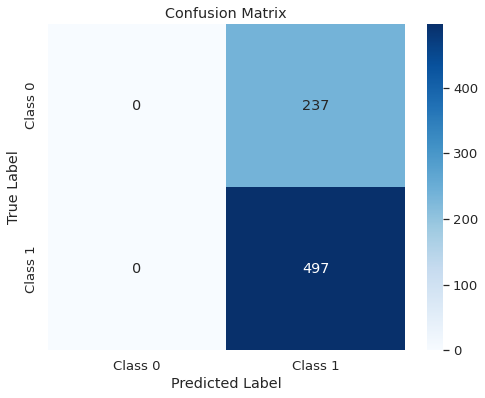

training loss has decreased---> reducing the global loss from 0.74 to 0.68
 epoch= 2 and mean train loss is 0.6824
 epoch= 2 : mean train loss is 0.6824 -> the accuracy is 0.68 ->the f1 is 0.68 
inside validation data for epoch 2
Val loss has decreased -->reducing the global validation loss from 0.61 to 0.57
 validation loss for epoch = 2 is 0.5701
 epoch= 2 : mean val loss is 0.5701 -> the accuracy is 0.70 ->the f1 is 0.70 
saving the model model2024-05-1511:35:50_mrpc.pth


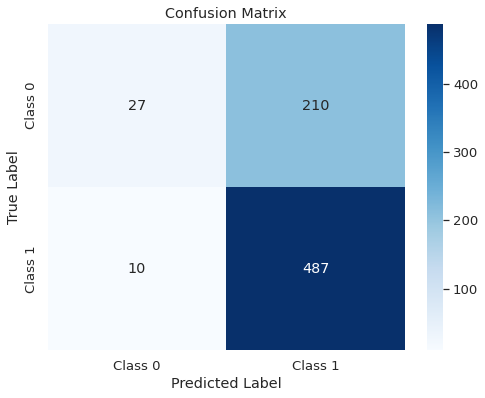

training loss has decreased---> reducing the global loss from 0.68 to 0.64
 epoch= 3 and mean train loss is 0.6383
 epoch= 3 : mean train loss is 0.6383 -> the accuracy is 0.72 ->the f1 is 0.72 
inside validation data for epoch 3
Val loss has decreased -->reducing the global validation loss from 0.57 to 0.55
 validation loss for epoch = 3 is 0.5532
 epoch= 3 : mean val loss is 0.5532 -> the accuracy is 0.73 ->the f1 is 0.73 
saving the model model2024-05-1511:37:07_mrpc.pth


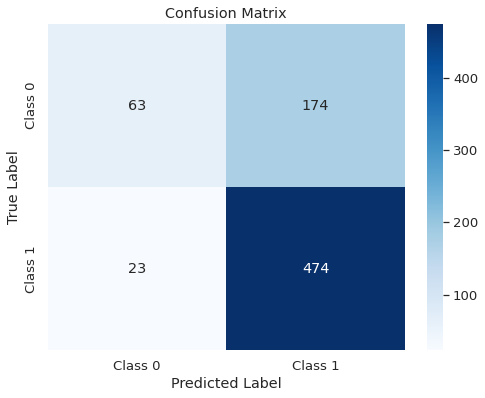

training loss has decreased---> reducing the global loss from 0.64 to 0.59
 epoch= 4 and mean train loss is 0.5857
 epoch= 4 : mean train loss is 0.5857 -> the accuracy is 0.76 ->the f1 is 0.76 
inside validation data for epoch 4
Val loss has decreased -->reducing the global validation loss from 0.55 to 0.54
 validation loss for epoch = 4 is 0.5428
 epoch= 4 : mean val loss is 0.5428 -> the accuracy is 0.72 ->the f1 is 0.72 
saving the model model2024-05-1511:38:25_mrpc.pth


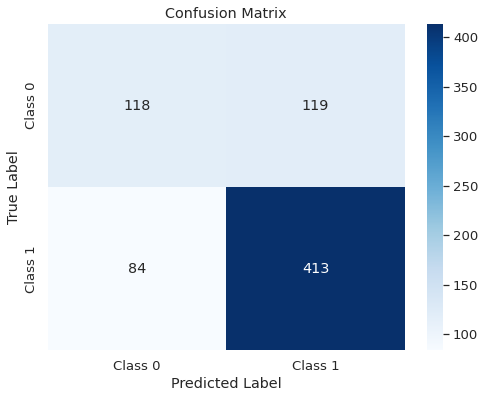

training loss has decreased---> reducing the global loss from 0.59 to 0.53
 epoch= 5 and mean train loss is 0.5270
 epoch= 5 : mean train loss is 0.5270 -> the accuracy is 0.79 ->the f1 is 0.79 
inside validation data for epoch 5
Val loss has decreased -->reducing the global validation loss from 0.54 to 0.54
 validation loss for epoch = 5 is 0.5375
 epoch= 5 : mean val loss is 0.5375 -> the accuracy is 0.72 ->the f1 is 0.72 
saving the model model2024-05-1511:39:42_mrpc.pth


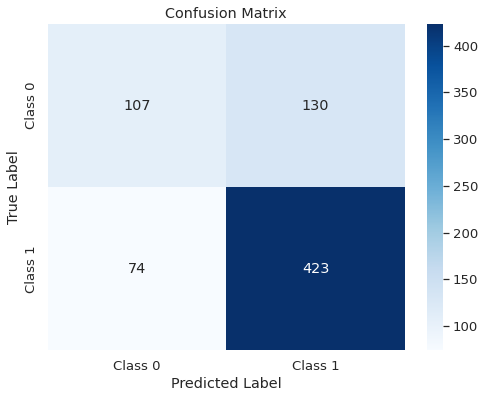

training loss has decreased---> reducing the global loss from 0.53 to 0.45
 epoch= 6 and mean train loss is 0.4465
 epoch= 6 : mean train loss is 0.4465 -> the accuracy is 0.84 ->the f1 is 0.84 
inside validation data for epoch 6
No improvement in validation loss-->epoch= 6 and global val loss is 0.5375
training loss has decreased---> reducing the global loss from 0.45 to 0.38
 epoch= 7 and mean train loss is 0.3773
 epoch= 7 : mean train loss is 0.3773 -> the accuracy is 0.89 ->the f1 is 0.89 
inside validation data for epoch 7
No improvement in validation loss-->epoch= 7 and global val loss is 0.5375
training loss has decreased---> reducing the global loss from 0.38 to 0.29
 epoch= 8 and mean train loss is 0.2924
 epoch= 8 : mean train loss is 0.2924 -> the accuracy is 0.93 ->the f1 is 0.93 
inside validation data for epoch 8
No improvement in validation loss-->epoch= 8 and global val loss is 0.5375
training loss has decreased---> reducing the global loss from 0.29 to 0.23
 epoch= 9 

KeyboardInterrupt: 

In [24]:
model = clf_model_drp()

#train_loader,optimizer,val_loader ,num_epoch = 100, model = clf_model()
tr_model = train_model(train_loader, val_loader )

def train_model_debug(train_loader,optimizer,val_loader ,num_epoch = 50, model = clf_model_debug()):
    model.train()
    for ind,(x_dict, label_vec) in enumerate(train_loader):
        model.to(device)
        #print(next(model_gpu.parameters()).device)

        id_list = x_dict['id']
        id_tensor = torch.squeeze(torch.tensor(id_list),dim = 1)
        #print(f"shape of ids->{id_tensor.shape}")

        tok_type_list = x_dict['token_type']
        tok_type_tensor = torch.squeeze(torch.tensor(tok_type_list),dim = 1)

        #token_type = torch.squeeze(torch.tensor(,dtype=torch.long).clone().detach(), dim = 1)
        #print(f"shape of token_type->{tok_type_tensor.shape}")

        att_list = x_dict['attention_mask']
        att_mask_tensor = torch.squeeze(torch.tensor(att_list),dim = 1)
        #att_mask = torch.squeeze(torch.tensor(,dtype=torch.long).clone().detach(), dim = 1)
        #print(f"shape of att_mask->{att_mask_tensor.shape}")

        ids_gpu = id_tensor.to(device)
        #print(f"ids = {ids_gpu}")
        #ids.to(device)
        #print(ids_gpu.device)

        token_type_gpu = tok_type_tensor.to(device)
        #print(token_type_gpu.device)

        att_mask_gpu = att_mask_tensor.to(device)
        #print(att_mask_gpu.device)



        labal_vec_gpu = label_vec.float().to(device)
        #print(f" labal_vec_gpu = {labal_vec_gpu}")

        logits = model(ids_gpu ,token_type_gpu,att_mask_gpu)
        optimizer.zero_grad(set_to_none=True)
        loss = nn.BCELoss()
        output = loss(logits, labal_vec_gpu)
        #print(f"loss for batch_index->{ind} is {output.item()}")

        #loss = torch.nn.BCEWithLogitsLoss(logits, labal_vec_gpu)
        output.backward()
        optimizer.step()
        train_loss_list.append(output.item())
        print(f"batch_ind{ind} and its loss is {output.item()}")

        #print(f" epoch= {i} and mean train loss is {torch.mean(torch.tensor(train_loss_list))}")
        #eval_model(val_loader, model, i , device = device)
        
    
    return model